# __Credit Card Routing System__

This is the main notebook of the project and is divided by _ parts:
- Exploratory Data Analysis
- Data Cleansing

### Main Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Exploratory Data Analysis

__Histogram of Distribution of Transactions__

   Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3           3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
4           4 2019-01-01 00:04:33  Austria     124        0  Simplecard   

   3D_secured    card  
0           0    Visa  
1           0    Visa  
2           1  Diners  
3           1  Diners  
4           0  Diners  


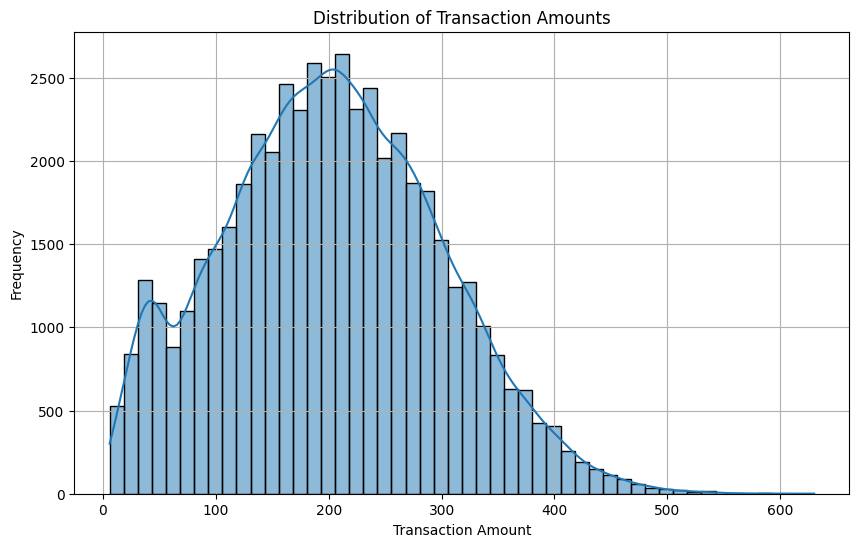

In [2]:
# This line is responsible for loeading the Excel dataset
df = pd.read_excel('data/PSP_Jan_Feb_2019.xlsx')

print(df.head())

# This snippet is for plotting the histogram of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
# plt.xlim(0, df['amount'].quantile(0.99))
plt.grid(True)
plt.show()

__Bar Chart with the Success Rate by 3D-Secure Status__

C:\Users\imildo.sitoe\AppData\Local\Temp\ipykernel_40796\3103473372.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='3D_secured', y='success', data=secure_success_rates, palette='coolwarm')


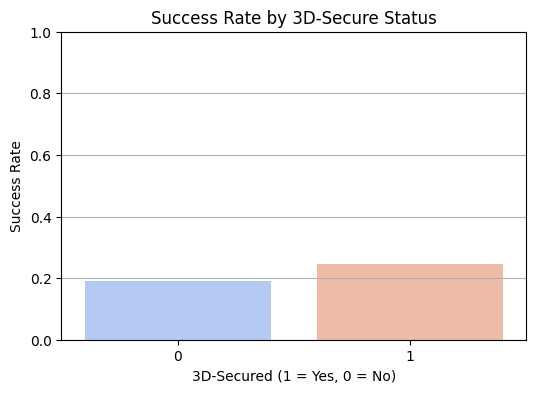

In [17]:
# This snippet is for calculating the success rate by 3D-secure status
secure_success_rates = df.groupby('3D_secured')['success'].mean().reset_index()

# Plot success rates by 3D-secured status
plt.figure(figsize=(6, 4))
sns.barplot(x='3D_secured', y='success', data=secure_success_rates, palette='coolwarm')
plt.title('Success Rate by 3D-Secure Status')
plt.xlabel('3D-Secured (1 = Yes, 0 = No)')
plt.ylabel('Success Rate')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

__Bar Chart with the Transaction Success Rates by PSP__

C:\Users\imildo.sitoe\AppData\Local\Temp\ipykernel_40796\3869572457.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PSP', y='success', data=psp_success_rates, palette='viridis')


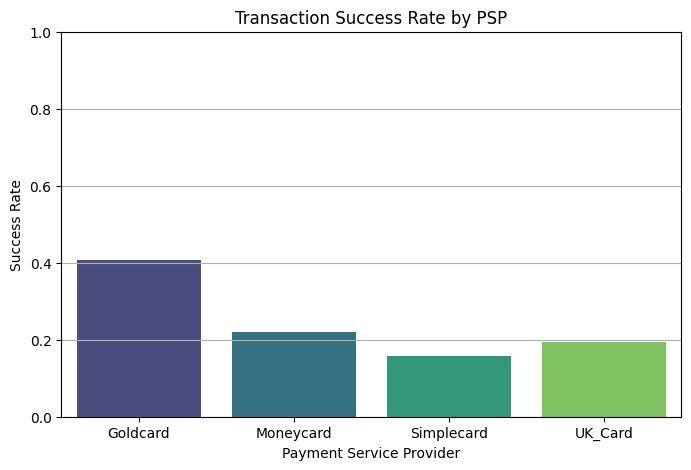

In [18]:
# Line to calculate the success rates per each PSP
psp_success_rates = df.groupby('PSP')['success'].mean().reset_index()

# Snippet to plot success rates by PSP
plt.figure(figsize=(8, 5))
sns.barplot(x='PSP', y='success', data=psp_success_rates, palette='viridis')
plt.title('Transaction Success Rate by PSP')
plt.xlabel('Payment Service Provider')
plt.ylabel('Success Rate')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

__Retry Patterns__

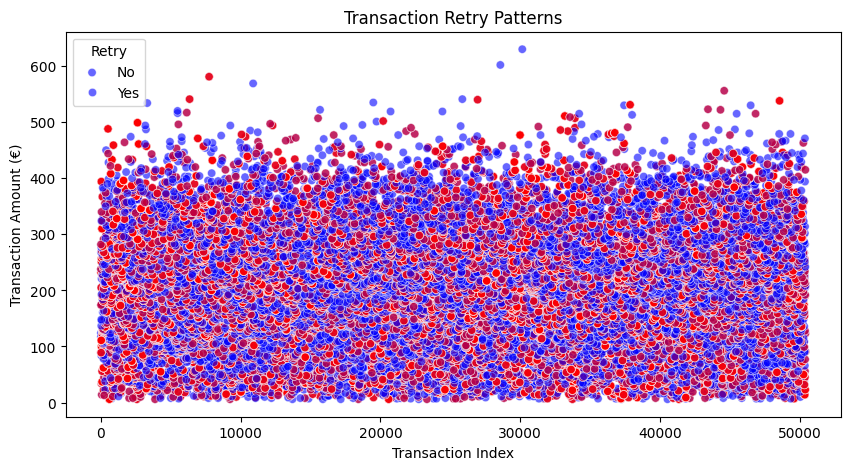

In [4]:
# Convert timestamp to datetime format
df['tmsp'] = pd.to_datetime(df['tmsp'])

# Sort values for easier comparison
df = df.sort_values(by=['country', 'amount', 'tmsp'])

# Identify retries (transactions within 1 minute with the same amount & country)
df['retry'] = (df.groupby(['country', 'amount'])['tmsp'].diff().dt.total_seconds() <= 60).astype(int)

# Plot retry patterns
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df.index, y='amount', hue='retry', data=df, palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title('Transaction Retry Patterns')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount (€)')
plt.legend(title='Retry', labels=['No', 'Yes'])
plt.show()
